In [ ]:
import os
import glob
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [ ]:
# Dataset Definition
class RetinaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_image=None, transform_mask=None):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.*")))
        self.mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.*")))

        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if random.random() > 0.5:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)

        if self.transform_image:
            image = self.transform_image(image)
        else:
            image = transforms.ToTensor()(image)

        if self.transform_mask:
            mask = self.transform_mask(mask)
        else:
            mask = transforms.ToTensor()(mask)

        mask = (mask > 0.5).float()
        return image, mask

In [ ]:
# Model Components
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.double_conv(x)

In [ ]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, dropout=dropout)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

In [ ]:
class Up(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, bilinear=True, dropout=0.0):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2)
        self.attention = AttentionBlock(F_g=in_channels, F_l=skip_channels, F_int=skip_channels // 2)
        self.conv = DoubleConv(in_channels + skip_channels, out_channels, dropout=dropout)
    def forward(self, x, skip):
        x = self.up(x)
        if x.size() != skip.size():
            diffY = skip.size()[2] - x.size()[2]
            diffX = skip.size()[3] - x.size()[3]
            x = nn.functional.pad(x, [diffX // 2, diffX - diffX // 2,
                                      diffY // 2, diffY - diffY // 2])

        # Apply attention to the skip connection
        skip = self.attention(g=x, x=skip)
        # Concatenate attention-refined skip features with upsampled features
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

In [ ]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

In [ ]:
# Attention U-Net Model
class AttentionUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True, dropout=0.1):
        super(AttentionUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64, dropout=dropout)
        self.down1 = Down(64, 128, dropout=dropout)
        self.down2 = Down(128, 256, dropout=dropout)
        self.down3 = Down(256, 512, dropout=dropout)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor, dropout=dropout)
        self.up1 = Up(1024 // factor, 512, 512 // factor, bilinear, dropout=dropout)
        self.up2 = Up(512 // factor, 256, 256 // factor, bilinear, dropout=dropout)
        self.up3 = Up(256 // factor, 128, 128 // factor, bilinear, dropout=dropout)
        self.up4 = Up(128 // factor, 64, 64, bilinear, dropout=dropout)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)      # Encoder stage 1
        x2 = self.down1(x1)   # Encoder stage 2
        x3 = self.down2(x2)   # Encoder stage 3
        x4 = self.down3(x3)   # Encoder stage 4
        x5 = self.down4(x4)   # Bottleneck
        x = self.up1(x5, x4)  # Decoder stage 1
        x = self.up2(x, x3)   # Decoder stage 2
        x = self.up3(x, x2)   # Decoder stage 3
        x = self.up4(x, x1)   # Decoder stage 4
        logits = self.outc(x)
        return logits

In [ ]:
# Loss Functions & Metrics
def dice_coef(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        d_loss = dice_loss(pred, target)
        return bce_loss + d_loss

In [ ]:
# Training & Evaluation Functions
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_dice = 0
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_dice += dice_coef(outputs, masks).item()

    return epoch_loss / len(dataloader), epoch_dice / len(dataloader)

In [ ]:
def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_dice = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            epoch_loss += loss.item()
            epoch_dice += dice_coef(outputs, masks).item()

    return epoch_loss / len(dataloader), epoch_dice / len(dataloader)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100] Train Loss: 1.4022, Train Dice: 0.2565 | Val Loss: 1.4580, Val Dice: 0.0000
Epoch [2/100] Train Loss: 1.2701, Train Dice: 0.4040 | Val Loss: 1.2366, Val Dice: 0.0878
Epoch [3/100] Train Loss: 1.1813, Train Dice: 0.5109 | Val Loss: 1.1140, Val Dice: 0.4854
Epoch [4/100] Train Loss: 1.1269, Train Dice: 0.5639 | Val Loss: 1.0761, Val Dice: 0.5133
Epoch [5/100] Train Loss: 1.0898, Train Dice: 0.5883 | Val Loss: 1.0477, Val Dice: 0.6094
Epoch [6/100] Train Loss: 1.0512, Train Dice: 0.6220 | Val Loss: 1.0248, Val Dice: 0.6058
Epoch [7/100] Train Loss: 1.0200, Train Dice: 0.6435 | Val Loss: 1.0042, Val Dice: 0.6356
Epoch [8/100] Train Loss: 0.9943, Train Dice: 0.6615 | Val Loss: 0.9789, Val Dice: 0.6494
Epoch [9/100] Train Loss: 0.9663, Train Dice: 0.6796 | Val Loss: 0.9559, Val Dice: 0.7021
Epoch [10/100] Train Loss: 0.9406, Train Dice: 0.6955 | Val Loss: 0.9421, Val Dice: 0.6973
Epoch [11/100] Train Loss: 0.9208, Train Dice: 0.7078 | Val Loss: 0.9078, Val Dice: 0.7185
Epoch [1

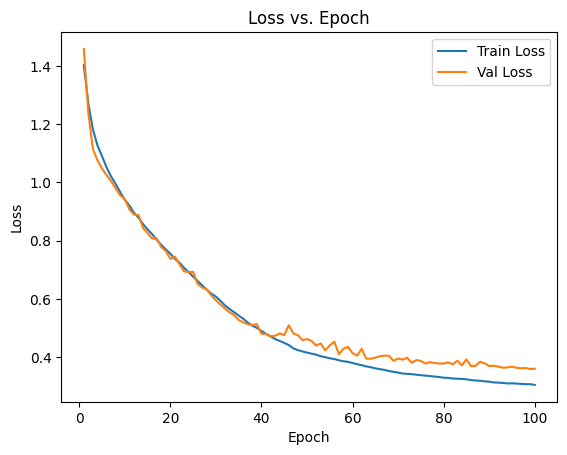

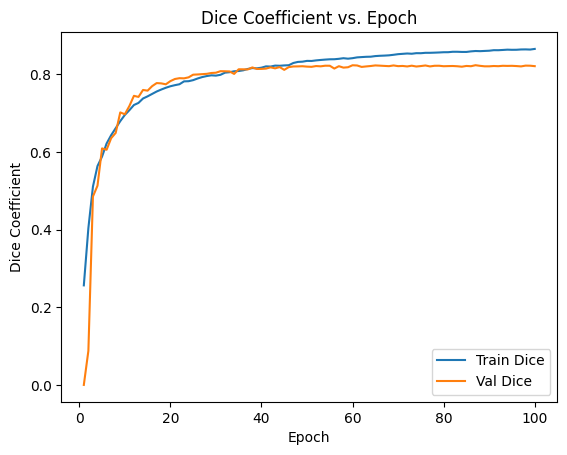

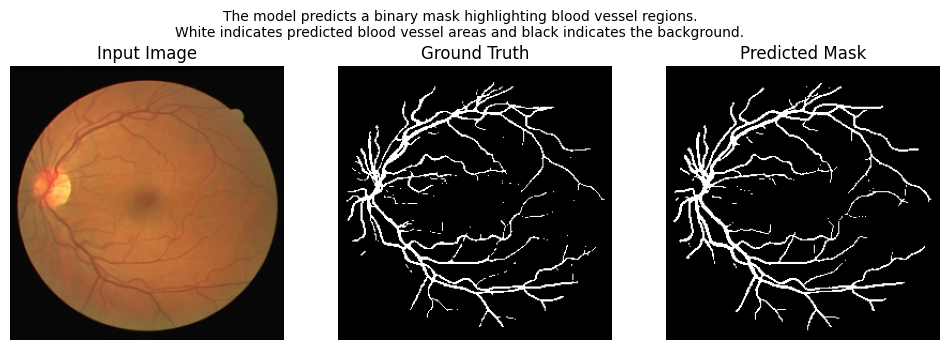

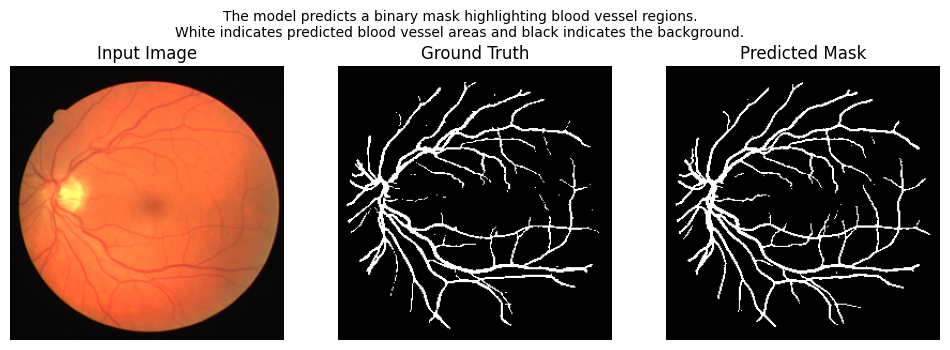

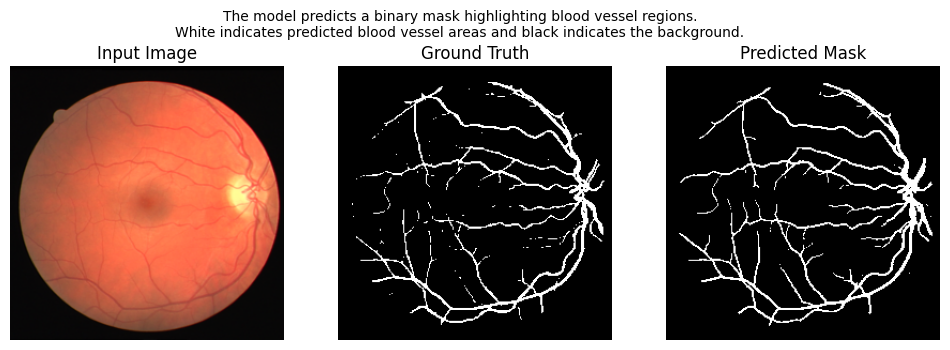

In [ ]:
def main():
    # Paths to your dataset directories
    train_img_dir = "/content/drive/MyDrive/Retina Blood Vessel/Data/train/image"
    train_mask_dir = "/content/drive/MyDrive/Retina Blood Vessel/Data/train/mask"
    test_img_dir  = "/content/drive/MyDrive/Retina Blood Vessel/Data/test/image"
    test_mask_dir = "/content/drive/MyDrive/Retina Blood Vessel/Data/test/mask"

    # Define image and mask transformations (resize as needed)
    image_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        # Normalize using ImageNet stats; adjust if needed
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    mask_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    # Create Dataset objects
    train_dataset = RetinaDataset(train_img_dir, train_mask_dir,
                                  transform_image=image_transform,
                                  transform_mask=mask_transform)
    test_dataset = RetinaDataset(test_img_dir, test_mask_dir,
                                 transform_image=image_transform,
                                 transform_mask=mask_transform)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize model, loss function, optimizer, and scheduler
    model = AttentionUNet(n_channels=3, n_classes=1, bilinear=True, dropout=0.1).to(device)
    criterion = BCEDiceLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    num_epochs = 100
    best_val_dice = 0.0

    # Lists for tracking training progress
    train_losses, train_dices = [], []
    val_losses, val_dices = [], []

    # Training loop
    for epoch in range(num_epochs):
        train_loss, train_dice = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_dice = eval_epoch(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        train_dices.append(train_dice)
        val_losses.append(val_loss)
        val_dices.append(val_dice)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")

        scheduler.step(val_loss)

    print("Training complete.")

    plt.figure()
    plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
    plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epoch")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(range(1, num_epochs+1), train_dices, label="Train Dice")
    plt.plot(range(1, num_epochs+1), val_dices, label="Val Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Dice Coefficient")
    plt.title("Dice Coefficient vs. Epoch")
    plt.legend()
    plt.show()

    model.eval()
    with torch.no_grad():
        for i in range(3):
            image, mask = test_dataset[i]
            image_input = image.unsqueeze(0).to(device)
            output = model(image_input)
            pred_mask = torch.sigmoid(output).cpu().squeeze().numpy()
            pred_mask = (pred_mask > 0.5).astype(np.uint8)

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            inv_normalize = transforms.Normalize(
                mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                std=[1/0.229, 1/0.224, 1/0.225]
            )
            img_vis = inv_normalize(image).clamp(0,1)
            axs[0].imshow(np.transpose(img_vis.numpy(), (1, 2, 0)))
            axs[0].set_title("Input Image")
            axs[1].imshow(mask.squeeze(), cmap='gray')
            axs[1].set_title("Ground Truth")
            axs[2].imshow(pred_mask, cmap='gray')
            axs[2].set_title("Predicted Mask")
            for ax in axs:
                ax.axis('off')

            plt.suptitle("The model predicts a binary mask highlighting blood vessel regions.\n"
                         "White indicates predicted blood vessel areas and black indicates the background.", fontsize=10)
            plt.show()